In [1]:
!pip install scikit-learn pandas numpy

## **1. Import Required Libraries**
Installs and imports required libraries for data processing, clustering, visualization, and similarity computations.  

- **Pandas & NumPy** → For data manipulation and numerical operations.  
- **Scikit-learn** → For clustering (KMeans, DBSCAN), scaling (StandardScaler), PCA (dimensionality reduction), and cosine similarity calculations.  
- **Scipy** → For distance calculations.  
- **TQDM** → Provides a progress bar for processing large datasets.  



In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import logging
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

## **2. Load and Prepare Data**
Downloads the Spotify dataset from Kaggle and loads three datasets:  

- **df_audio.csv** → User's listening history (without audio features).  
- **overlapping_songs_with_features.csv** → Extracted audio features for songs the user has already listened to.  
- **spotify_features.csv** → Large dataset with Spotify's track features.  

These datasets are combined to match user preferences with new songs that share similar characteristics.  

---


In [4]:
# Download latest version
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")
spotify_features = pd.read_csv('/root/.cache/kagglehub/datasets/maharshipandya/-spotify-tracks-dataset/versions/1/dataset.csv')
# Read the required Dataset
df_audio = pd.read_csv('df_audio.csv')
overlapping_songs = pd.read_csv('/content/overlapping_songs_with_features.csv')

<ipython-input-4-a34e88b3ac75>:5: DtypeWarning: Columns (12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_audio = pd.read_csv('df_audio.csv')



## **3. Cluster Analysis (Understanding Listening Preferences)**
Groups songs into clusters based on their audio features to identify different music styles in the user’s history.  

### **Why K-Means?**  
- K-Means groups similar songs by minimizing the distance between each song and its assigned cluster center.  
- PCA is used before clustering to reduce the number of features, improving efficiency.  

### **Why the top 3 dominant clusters?**  
- One cluster would be too restrictive.  
- Too many clusters would reduce personalization.  
- Three clusters provide diversity while keeping recommendations relevant.  

Each song is assigned to a cluster, helping categorize listening habits before generating recommendations.  

---



In [10]:
# Define audio feature columns
audio_features_columns = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
    'duration_ms', 'time_signature'
]

# Ensure clusters exist
if 'cluster' not in overlapping_songs.columns:
    print("Clusters are not assigned yet. Run clustering before analyzing features.")
else:
    # Compute mean and standard deviation per cluster
    cluster_summary = overlapping_songs.groupby('cluster')[audio_features_columns].agg(['mean', 'std'])

    # Display the DataFrame in Colab
    from IPython.display import display
    display(cluster_summary)

    # Save summary for reference
    cluster_summary.to_csv("cluster_summary.csv")


danceability              energy                 key            \
                mean       std      mean       std      mean       std   
cluster                                                                  
0           0.621988  0.114221  0.760992  0.134427  1.507675  1.486103   
1           0.514252  0.134659  0.362450  0.118193  4.928690  3.259011   
2           0.629930  0.119731  0.756611  0.141511  5.621180  3.598946   
3           0.518577  0.162298  0.705337  0.238024  6.204082  3.727743   
4           0.526556  0.129038  0.806358  0.159408  5.132353  3.186661   
6           0.337935  0.241432  0.417809  0.329122  5.260870  3.506065   
7           0.406823  0.096876  0.814426  0.142551  5.108044  3.199521   
8           0.640591  0.106066  0.742323  0.147461  8.047664  1.794717   
9           0.452962  0.204191  0.198144  0.144282  5.516340  3.466199   

          loudness                 mode            ...  liveness            \
              mean        std      mean       std  ...      mean       std   
cluster                                            ...                       
0        -5.709377   2.194492  1.000000  0.000000  ...  0.177843  0.112922   
1       -10.407313   3.114060  0.807629  0.394491  ...  0.144668  0.079494   
2        -5.774884   2.271021  0.000000  0.000000  ...  0.164635  0.103864   
3        -7.911796   3.051249  0.500000  0.502571  ...  0.176679  0.112460   
4        -5.668137   2.700545  0.730392  0.444848  ...  0.680789  0.131559   
6       -17.637174  14.570120  0.652174  0.486985  ...  0.200704  0.186213   
7        -5.129027   1.816653  0.660883  0.473596  ...  0.183419  0.113722   
8        -6.032442   2.405323  1.000000  0.000000  ...  0.163648  0.108835   
9       -19.961039   6.584636  0.640523  0.481423  ...  0.154743  0.142938   

          valence                 tempo               duration_ms  \
             mean       std        mean        std           mean   
cluster                                                             
0        0.606413  0.211951  116.838601  22.281185  219615.115132   
1        0.316279  0.171931  109.325731  29.281587  230265.698176   
2        0.575922  0.215950  116.445590  23.309820  226008.729211   
3        0.357668  0.231775  117.427755  26.474207  265750.448980   
4        0.515825  0.201514  120.194603  23.739909  233203.338235   
6        0.260683  0.221003   94.110130  52.136616  184891.347826   
7        0.338661  0.165339  148.756677  26.923719  259871.388013   
8        0.617210  0.204551  117.545780  22.496813  225842.778837   
9        0.162052  0.134578  108.322405  29.321002  187125.895425   

                       time_signature            
                   std           mean       std  
cluster                                          
0         40718.826408       3.998904  0.144413  
1         60706.234858       3.829187  0.414453  
2         42134.386993       3.985075  0.157068  
3        115281.991930       3.989796  0.226807  
4         72729.725597       3.985294  0.120669  
6         81926.222239       0.826087  0.387553  
7         65095.942727       3.911672  0.300102  
8         43358.250055       3.998093  0.075641  
9        107586.510642       3.856209  0.464791  

[9 rows x 26 columns]

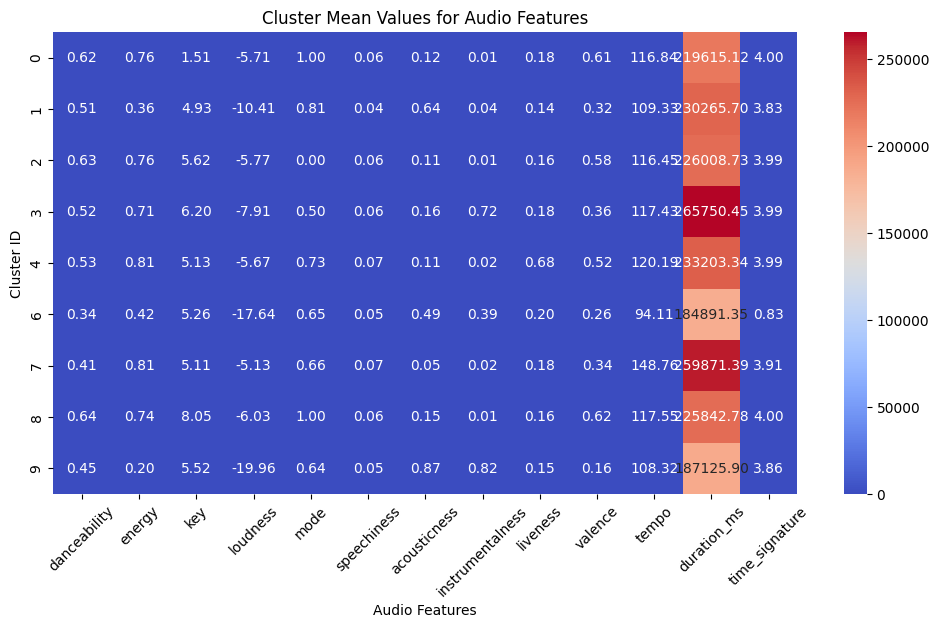

In [11]:
# Visualizing Cluster Statistics
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_summary.xs('mean', axis=1, level=1), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cluster Mean Values for Audio Features")
plt.xlabel("Audio Features")
plt.ylabel("Cluster ID")
plt.xticks(rotation=45)
plt.show()

## **4. Generate Recommendations**
Selects new songs from the same dominant clusters in the larger Spotify dataset.  

### **Why Cosine Similarity?**  
- Measures how similar two sets of audio features are, regardless of scale.  
- Ensures recommended songs closely match the user's past preferences.  

Songs are sorted based on similarity scores to the user's profile.  

---

## **5. Enforcing Diversity in Recommendations**
Ensures only one song per artist to avoid repetition.  

### **Why use softmax and weighted probabilities?**  
- Prevents the same top songs from being recommended every time.  
- Softmax scaling converts similarity scores into probabilities.  
- Randomly selects from the top 50 songs, prioritizing those with higher scores.  

This ensures recommendations remain personalized yet dynamic.  

---

In [15]:
# Step 1: Identify the dominant clusters in your listening history
dominant_clusters = overlapping_songs['cluster'].value_counts().index[:3]

# Step 2: Select songs from the same dominant clusters in the Spotify dataset
recommended_songs = spotify_features[spotify_features['cluster'].isin(dominant_clusters)].copy()

# Step 3: Compute similarity scores between new songs and your past listening history
user_profile = overlapping_songs[audio_features_columns].mean()

# Normalize recommended songs
recommended_songs_normalized = scaler.transform(recommended_songs[audio_features_columns])
user_profile_normalized = scaler.transform(user_profile.values.reshape(1, -1))

# Compute cosine similarity
recommended_songs['similarity_score'] = cosine_similarity(
    recommended_songs_normalized, user_profile_normalized
).flatten()

# Step 4: Sort recommendations by similarity score
recommended_songs = recommended_songs.sort_values(by='similarity_score', ascending=False)

# Step 5: Ensure only one song per artist
unique_artist_recommendations = recommended_songs.drop_duplicates(subset=['artists'], keep='first')

# Step 6: Introduce randomness while keeping high similarity scores prioritized
top_n = 50  # Consider the top 50 high-scoring songs
if len(unique_artist_recommendations) > top_n:
    candidates = unique_artist_recommendations.head(top_n)

    # Apply softmax scaling to similarity scores to assign probabilities
    exp_scores = np.exp(candidates['similarity_score'])  # Exponential scaling
    probabilities = exp_scores / exp_scores.sum()  # Normalize to get probabilities

    # Randomly sample 20 songs based on weighted probabilities
    top_recommendations = candidates.sample(n=20, weights=probabilities, random_state=np.random.randint(0, 10000))
else:
    top_recommendations = unique_artist_recommendations.head(20)  # Fallback if <50 songs available

# Step 7: Display top recommendations
import IPython.display as display
display.display(top_recommendations[['track_name', 'artists', 'similarity_score']])


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,track_name,artists,similarity_score
44154,I'LL BE GONE,Linkin Park,0.796434
50155,Tuli Vesi Ilma Ja Maa,Kilpi,0.814338
113489,Hallelujah Anyway,Rend Collective,0.789831
79690,Bend & Break,Keane,0.838478
39847,Wünsch dir was,Die Toten Hosen,0.824865
91479,Simple Life,Lynyrd Skynyrd,0.818871
82202,Sweetness,Jimmy Eat World,0.789207
63033,Sunny drop,Novelbright,0.805067
78310,Sünderlein,Brings,0.836286
50540,The Kids Who Wanna Play With The Dead,Lordi,0.795682





## **6. Saves the Final Personalized Playlist**
The recommendations are saved as `personalized_playlist.csv` to match the format required by the Spotify playlist creation script.  

This file includes track names, artist names, and audio features, ensuring seamless playlist creation via the Spotify API.

In [16]:
# Step 8: Save the recommendations to a CSV file with the correct column names
top_recommendations.rename(columns={
    'track_name': 'master_metadata_track_name',
    'artists': 'master_metadata_album_artist_name'
}, inplace=True)

# Ensure only the necessary columns are saved
columns_to_save = [
    'master_metadata_track_name', 'master_metadata_album_artist_name',
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
    'duration_ms', 'time_signature'
]

# Save the playlist as CSV
top_recommendations.to_csv('personalized_playlist.csv', columns=columns_to_save, index=False)

print("Personalized playlist saved as 'personalized_playlist.csv'.")


Personalized playlist saved as 'personalized_playlist.csv'.
